<a href="https://colab.research.google.com/github/changeden/Reinforcement-learning-project/blob/main/EEC256_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATE Environment

In [ ]:
import numpy as np

class ATEEnv:
  def __init__(self):
    self.reset() #reset at the start and also after each recalibration

  def reset(self, age=5):
    self.temperature = round(np.random.uniform(20, 30), 1) #temperature(random floating point Celsius degree between 20 and 30)
    self.humidity = round(np.random.uniform(30, 60), 1) # realtive humidity(RH)(random floating point % between 30 and 60)
    self.age = age #assume the age is fixed and we can revise it as an input when calling reset
    self.drift = 0 #µV initial drift
    self.p_contamination = 0.0002 #probability of contamination
    self.time = 0 #initialize chip amount to zero
    self.done = False
    return self.get_state()

  def get_state(self):
    drift_bin = int(self.drift // 5) #so we don't get a large number of states that needs a lot of epochs to update all of them
    return drift_bin

  def rules(self, action, chip=None):
      reward = 0 #initialize reward
      recalibrated = False

      if self.time >= 2000: #2000 chips
        self.done = True
        reward -= 5 #running too long without recalibration
        return self.get_state(), reward, self.done, recalibrated

      if action == 1: #stop and recalibrate
        reward -= 1 #small negative reward for recalibration
        if 50< self.drift <100:
          reward += 10 #positive reward for recalibrating on time
        else:
          reward -= 20 #otherwise, negative reward

        self.reset() #recalibrate = reset
        recalibrated = True
        return self.get_state(), reward, self.done, recalibrated
      else: #conitnue testing
        self.time += 1 #add 1 chip count

      drifting = 0.05 * self.temperature + 0.03 * self.humidity + 0.5 * self.age #compute drifting level based on temperature, humidity, and age(the users can revise this line to the specific equation for their equipment)

      if np.random.rand() < self.p_contamination:
        drifting += np.random.uniform(10, 30) #random spike in drift due to contamination

      self.drift += np.random.normal(drifting * 0.5, 2) #add noise to form the final drift

      if self.drift > 100: #failure condition
            reward = -20
            self.done = True

      if chip is not None:
        predicted_label = int((2.8 <= chip["vout"] <= 3.3) and (chip["leakage"] < 20) and (chip["delay"] < 5)) #consider as a good chip only if it meets all requirements
        if predicted_label == chip["label"]:
          reward += 1 #positive reward for classifying correctly
        else:
          reward -=1 #otherwise, negative reward

      return self.get_state(), reward, self.done, recalibrated

# Chip Generating

In [ ]:
class ChipGenerating:
  def __init__(self, vout_u=3.0, vout_sigma=0.2, leakage_u=10, leakage_sigma=2, delay_u=3.5, delay_sigma=0.5): #the users can change these parameters to specific ones as their standard for good chip(these parameters are just what we found during research)
    #output voltage
    self.vout_u = vout_u
    self.vout_sigma = vout_sigma
    #leakage current
    self.leakage_u = leakage_u
    self.leakage_sigma = leakage_sigma
    #propagation delay
    self.delay_u = delay_u
    self.delay_sigma = delay_sigma

  def generate_chip(self):
    #define parameters
    vout = np.random.normal(self.vout_u, self.vout_sigma)
    leakage = np.random.normal(self.leakage_u, self.leakage_sigma)
    delay = np.random.normal(self.delay_u, self.delay_sigma)

    label = int((2.8 <= vout <= 3.3) and (leakage < 20) and (delay < 5)) #meet all requrements to be classified as a godd chip

    return{"vout": vout, "leakage": leakage, "delay": delay, "label": label}

  def generate_batch(self, n=100):
    return [self.generate_chip() for _ in range(n)]

# Main Loop

In [ ]:
import random
#initialize two dictionaries to store Q values for each (s, a) pair
Q1 = {}
Q2 = {}

def get_q(Q, state, action):
  return Q.get((state, action), 0) #function to get Q values for designated (s, a) pair from either Q dictionaries, if the (s, a) pair exists return (s, a), if not, return 0

def select_action(state, epsilon):
  if np.random.rand() < epsilon:
    return random.choice([0, 1]) #exploration(randomly select to keep testing or recalibrate)
  else:
    q1 = [get_q(Q1, state, a) for a in [0, 1]] #a list of Q values for both actions from Q1
    q2 = [get_q(Q2, state, a) for a in [0, 1]] #a list of Q values for both actions from Q2
    q_sum = [q1[i] + q2[i] for i in range(2)] # add up Q value in q1 and q2 index-wise
    return int(np.argmax(q_sum)) #exploitation based on double Q-learning(select the action that has larger sum of Q values form two dictionaries)

alpha = 0.1
gamma = 1
epsilon = 0.3
episodes = 100000

generator = ChipGenerating()
batch = generator.generate_batch(n=10000)

drift_values_first = [] #store the drift value at each step of the first episode for the plot later
recalibration_timesteps_first = [] #store all steps which the agent select to recalibrate for first episode
drift_values_last = [] #store the drift value at each step of the last episode for the plot later
recalibration_timesteps_last = [] #store all stpeps which the agent select to reclaibrate for last episode

for episode in range(episodes):
  env = ATEEnv()
  state = (env.reset(),)
  done = False
  step = 0
  max_step = 500
  if episode == episodes - 1:
    epsilon = 0 #set the epsilon for the last episode to zero so that the agent follows what it has learned and we can see if it makes sense

  while not done and step < max_step: #set a max step count, otherwise, if the agent has learned when to recalibrate, the episode is not gonna end
    chip = random.choice(batch) #select random chip in the batch to test
    action = select_action(state, epsilon)
    next_state_list, reward, done, recalibrated = env.rules(action, chip)
    next_state = (next_state_list,)

    if episode == episodes - 1: #record last episode
      drift_values_last.append(env.drift)
      if recalibrated:
        recalibration_timesteps_last.append(step)
    elif episode == 0: #record first episode
      drift_values_first.append(env.drift)
      if recalibrated:
        recalibration_timesteps_first.append(step)

    if random.random() < 0.5: #probability of 0.5 for both Q dictionaries to be updated
      best_action = np.argmax([get_q(Q1, next_state, a) for a in [0, 1]])
      target = reward +gamma * get_q(Q2, next_state, best_action)
      Q1[(state, action)] = get_q(Q1, state, action) + alpha * (target - get_q(Q1, state, action))
    else:
      best_action = np.argmax([get_q(Q2, next_state, a) for a in [0, 1]])
      target = reward +gamma * get_q(Q1, next_state, best_action)
      Q2[(state, action)] = get_q(Q2, state, action) + alpha * (target - get_q(Q2, state, action))

    state = next_state
    step += 1


  if episode % 100 == 0 or episode == 0:
    print(f"Episode {episode}")

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 2800
Episode 2900
Episode 3000
Episode 3100
Episode 3200
Episode 3300
Episode 3400
Episode 3500
Episode 3600
Episode 3700
Episode 3800
Episode 3900
Episode 4000
Episode 4100
Episode 4200
Episode 4300
Episode 4400
Episode 4500
Episode 4600
Episode 4700
Episode 4800
Episode 4900
Episode 5000
Episode 5100
Episode 5200
Episode 5300
Episode 5400
Episode 5500
Episode 5600
Episode 5700
Episode 5800
Episode 5900
Episode 6000
Episode 6100
Episode 6200
Episode 6300
Episode 6400
Episode 6500
Episode 6600
Episode 6700
Episode 6800
Episode 6900
Episode 7000
Episode 7100
Episode 7200
Episode 7300
Episode 7400
Episode 7500
Episode 7600
Episode 770

In [ ]:
print(drift_values_first)
print(recalibration_timesteps_first)
print(drift_values_last)
print(recalibration_timesteps_last)

[4.811837353804452, 10.073838562580633, 13.983460473161344, 14.3186851852233, 19.566948691943516, 0, 3.6652601664456634, 1.8033302051927187, 4.428443915089346, 0, 3.805854097838356, 7.366204891457112, 6.10601533285524, 6.774758442221927, 0, 2.7651909586187142, 5.782062057889252, 9.540745727572945, 0, 4.753985259816002, 6.501816774466539, 0, 4.918056362921925, 7.407231674434538, 11.434196938894175, 14.669991635982687, 0, 0, 0.7179224267560851, 3.4261187195588567, 5.235363550080617, 6.702597705446445, 0, 4.248966275418006, 5.3138598816252784, 6.580855047358607, 9.589236225974306, 10.164212616436615, 0, 0, 2.979636639180284, 4.722784396124851, 0, -1.3739946153294245, 0.697860469127979, 4.603463968791809, 0, 2.4134031125733544, 6.079611400460051, 0, 0, 0.5903924706237831, 2.9477528647585745, 7.9726609761614515, 11.760630979489644, 16.472986585336876, 0, -1.8757887176377555, 2.3249000063684413, 0, 4.219201064153481, 7.859526826192768, 0, 0, 3.098261877280379, 3.973285606573131, 8.8324874418

# Result

## Q-learning Model

In [ ]:
from tqdm import tqdm
def simulate_ATE(chip, Q1, Q2):
    env = ATEEnv()
    state = (env.reset(),)
    done = False
    step = 0
    max_step = 5000

    while not done and step < max_step:
        action = np.argmax([get_q(Q1, state, a) + get_q(Q2, state, a) for a in [0, 1]])
        next_state, reward, done ,recalibrated= env.rules(action, chip)
        state = (next_state,)
        step += 1

    drift = max(env.drift, 0) #ensure the drift is larger than zero

    #apply noise that caused by ATE drift
    vout = chip["vout"] + np.random.normal(0, drift * 0.002)
    leakage = chip["leakage"] + np.random.normal(0, drift * 0.0002)
    delay = chip["delay"] + np.random.normal(0, drift * 0.0002)

    predicted_label = int((2.8 <= vout <= 3.3) and (leakage < 20) and (delay < 5)) #predict as good chip only if it meets all requirements
    return predicted_label

from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
predicted_labels = []

for chip in tqdm(batch, desc="Evaluating chips"):
    true_labels.append(chip["label"])
    predicted_labels.append(simulate_ATE(chip, Q1, Q2))

#result
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Bad", "Good"]))

Evaluating chips: 100%|██████████| 10000/10000 [10:45<00:00, 15.48it/s]


Confusion Matrix:
[[1953  284]
 [ 483 7280]]

Classification Report:
              precision    recall  f1-score   support

         Bad       0.80      0.87      0.84      2237
        Good       0.96      0.94      0.95      7763

    accuracy                           0.92     10000
   macro avg       0.88      0.91      0.89     10000
weighted avg       0.93      0.92      0.92     10000



### Plots for First and Last Episode

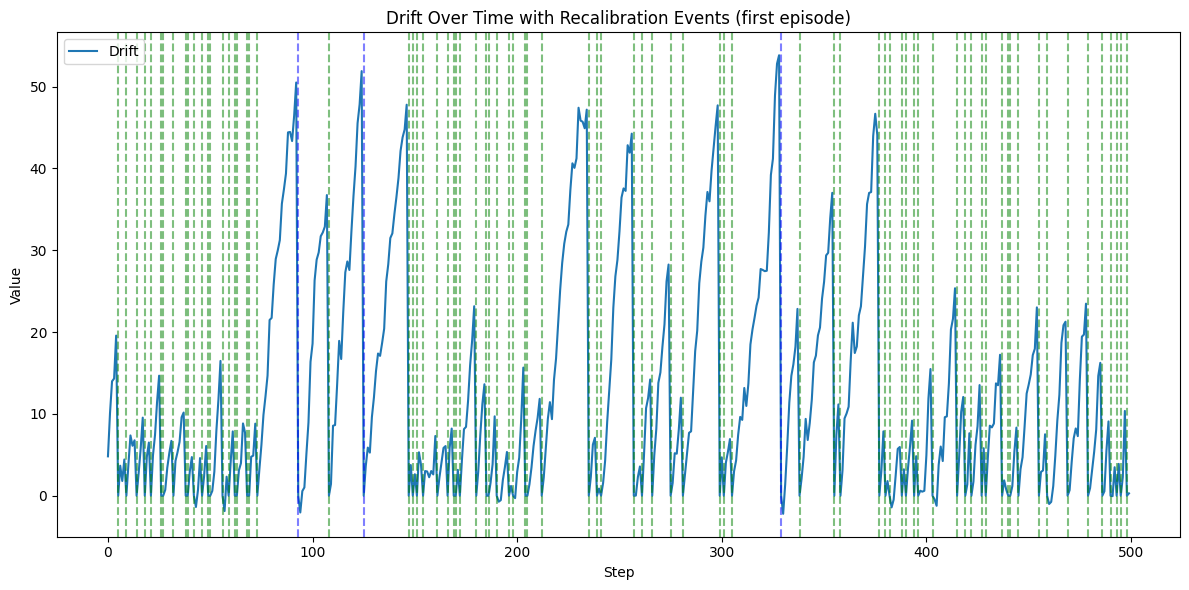

In [ ]:
import matplotlib.pyplot as plt

timesteps = list(range(len(drift_values_first)))

plt.figure(figsize=(12, 6))
plt.plot(timesteps, drift_values_first, label='Drift')

for t in recalibration_timesteps_first:
    d = drift_values_first[t-1]
    if d < 50:
        color = 'green' #too Early
    elif 50 <= d < 100:
        color = 'blue' #on Time
    else:
        color = 'red' #too Late
    plt.axvline(x=t, color=color, linestyle='--', alpha=0.5)

plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Drift Over Time with Recalibration Events (first episode)')
plt.legend()
plt.tight_layout()
plt.show()

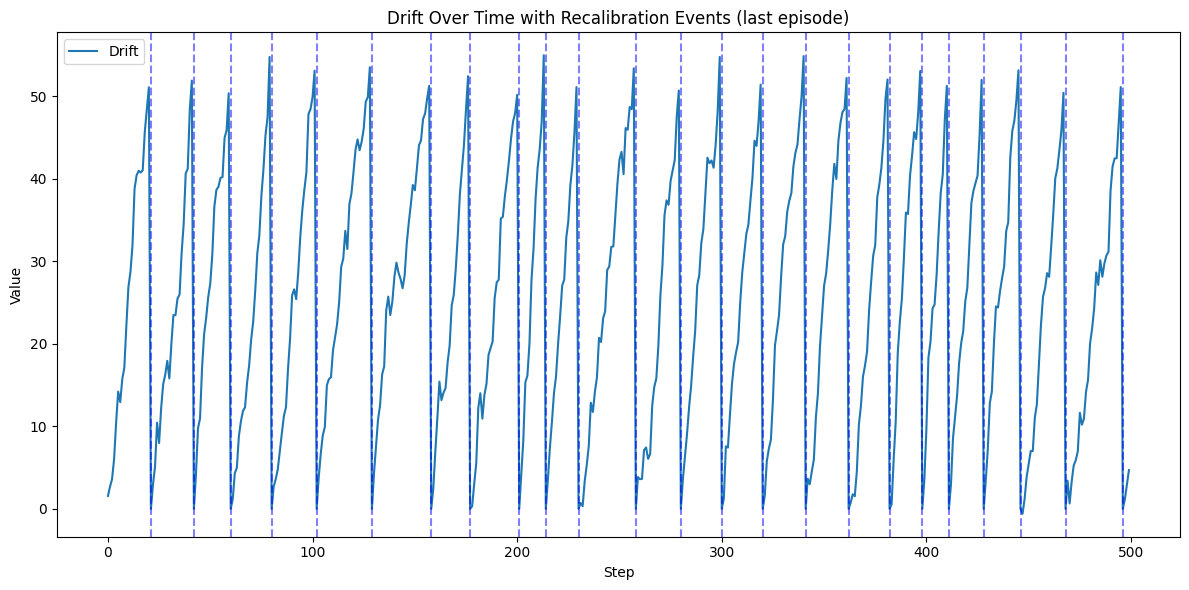

In [ ]:
import matplotlib.pyplot as plt

timesteps = list(range(len(drift_values_last)))

plt.figure(figsize=(12, 6))
plt.plot(timesteps, drift_values_last, label='Drift')

for t in recalibration_timesteps_last:
    d = drift_values_last[t-1]
    if d < 50:
        color = 'green' #too Early
    elif 50 <= d < 100:
        color = 'blue' #on Time
    else:
        color = 'red' #too Late
    plt.axvline(x=t, color=color, linestyle='--', alpha=0.5)

plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Drift Over Time with Recalibration Events (last episode)')
plt.legend()
plt.tight_layout()
plt.show()

## Model without Recalibration

In [ ]:
def simulate_ATE_always_test(chip):
    env = ATEEnv()
    state = env.reset()
    done = False
    step = 0
    max_step = 5000

    while not done and step < max_step:
        action = 0  #no recalibration (always testing)
        next_state, reward, done, recalibrated = env.rules(action, chip)
        state = next_state
        step += 1

    #apply drift noise to the chip
    drift = max(env.drift, 0)
    vout = chip["vout"] + np.random.normal(0, drift * 0.002)
    leakage = chip["leakage"] + np.random.normal(0, drift * 0.0002)
    delay = chip["delay"] + np.random.normal(0, drift * 0.0002)

    predicted_label = int((2.8 <= vout <= 3.3) and (leakage < 20) and (delay < 5))
    return predicted_label

true_labels = []
predicted_labels = []

for chip in tqdm(batch, desc="Evaluating without recalibration"):
    true_labels.append(chip["label"])
    predicted_labels.append(simulate_ATE_always_test(chip))

#result
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Bad", "Good"]))

Evaluating without recalibration: 100%|██████████| 10000/10000 [00:04<00:00, 2073.61it/s]

Confusion Matrix:
[[1506  731]
 [2356 5407]]

Classification Report:
              precision    recall  f1-score   support

         Bad       0.39      0.67      0.49      2237
        Good       0.88      0.70      0.78      7763

    accuracy                           0.69     10000
   macro avg       0.64      0.68      0.64     10000
weighted avg       0.77      0.69      0.71     10000



## Threshold-Based Model(commonly use in industry)


In [ ]:
def simulate_ATE_threshold(chip, threshold=50):
    env = ATEEnv()
    state = env.reset()
    done = False
    step = 0
    max_step = 5000

    while not done and step < max_step:
        if env.drift > threshold:
          action = 1 #recalibrate if the drift exceeds the threshold
        else:
          action = 0

        next_state, reward, done, recalibrated = env.rules(action, chip)
        state = next_state
        step += 1

    #apply drift noise to the chip
    drift = max(env.drift, 0)
    vout = chip["vout"] + np.random.normal(0, drift * 0.002)
    leakage = chip["leakage"] + np.random.normal(0, drift * 0.0002)
    delay = chip["delay"] + np.random.normal(0, drift * 0.0002)

    predicted_label = int((2.8 <= vout <= 3.3) and (leakage < 20) and (delay < 5))
    return predicted_label

true_labels = []
predicted_labels = []

for chip in tqdm(batch, desc="Evaluating with threshold based recalibration"):
    true_labels.append(chip["label"])
    predicted_labels.append(simulate_ATE_threshold(chip))

#result
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Bad", "Good"]))

Evaluating with threshold based recalibration: 100%|██████████| 10000/10000 [03:20<00:00, 49.91it/s]


Confusion Matrix:
[[1937  300]
 [ 482 7281]]

Classification Report:
              precision    recall  f1-score   support

         Bad       0.80      0.87      0.83      2237
        Good       0.96      0.94      0.95      7763

    accuracy                           0.92     10000
   macro avg       0.88      0.90      0.89     10000
weighted avg       0.92      0.92      0.92     10000

